<a href="https://colab.research.google.com/github/MBrandao07/Prevencao-a-Fraudes/blob/main/Codigos/1_Preven%C3%A7%C3%A3o_a_Fraude_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entendimento do Negócio

Com o aumento das transações eletrônicas em pontos de venda físicos, o uso de cartões de crédito tornou-se essencial no cotidiano. No entanto, essa facilidade também trouxe um aumento nas fraudes, incluindo transações fraudulentas em terminais físicos comprometidos e ataques direcionados a esses locais.

Fraudes em terminais físicos prejudicam financeiramente as instituições e afetam a confiança dos consumidores, além de impactar negativamente a reputação das empresas envolvidas. Por isso, a PoDShield enfrenta uma demanda crescente por soluções automatizadas que possam examinar rapidamente grandes volumes de transações e identificar padrões de fraude em terminais físicos. <br><br>

**Objetivo:**

Desenvolver um modelo de machine learning para detecção de fraudes em cartões de crédito, focado exclusivamente em transações realizadas em terminais físicos.

# Entendimento dos Dados

Temos 4 tabelas que serão utilizadas como base de dados, sendo elas:

- Terminal

- Train

- Test

- Customer

Essas tabelas se relacionam da seguinte maneira:

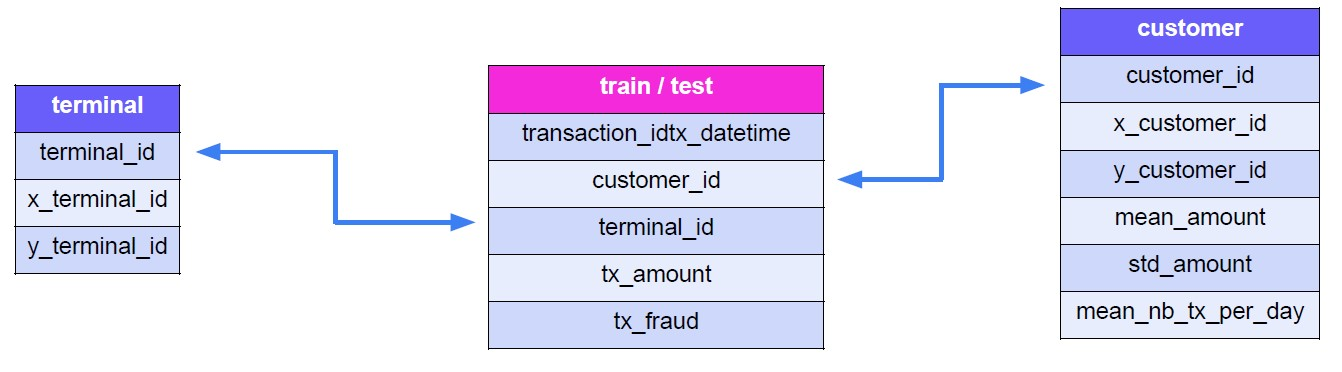

In [ ]:
!pip install cartopy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# conectando ao drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Funções

In [ ]:
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata


def classify_period(hour):
    if 5 <= hour < 12:
        return 'manhã'
    elif 12 <= hour < 18:
        return 'tarde'
    else:
        return 'noite'

### Importando as bases de dados

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/2 - Projetos Portfolio/Prevencao de Fraude/Base de dados/train.csv")
train.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,59383,2021-08-01 00:04:37,323,217,4.60,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0


In [ ]:
train.shape

(291231, 6)

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/2 - Projetos Portfolio/Prevencao de Fraude/Base de dados/test.csv")
test.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT
0,352590,2022-01-01 00:03:14,208,640,147.24
1,352591,2022-01-01 00:26:39,851,315,13.27
2,352592,2022-01-01 00:30:30,454,27,70.52
3,352593,2022-01-01 00:31:31,677,1573,44.75
4,352594,2022-01-01 00:56:18,322,1398,37.60


In [ ]:
test.shape

(226731, 5)

In [ ]:
customer = pd.read_csv("/content/drive/MyDrive/2 - Projetos Portfolio/Prevencao de Fraude/Base de dados/customer.csv")
customer.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,10.950170,59.768684,62.262521,31.131260,2.179533
1,1,13.671851,52.775318,46.570785,23.285393,3.567092
2,2,-9.381829,38.617619,80.213879,40.106939,2.115580
3,3,-3.745116,40.551744,11.748426,5.874213,0.348517
4,4,4.312412,51.067100,78.924891,39.462446,3.480049


In [ ]:
customer.shape

(1000, 6)

In [ ]:
terminal = pd.read_csv("/content/drive/MyDrive/2 - Projetos Portfolio/Prevencao de Fraude/Base de dados/terminal.csv")
terminal.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,9.388886,44.298820
1,1,12.204779,38.423219
2,2,16.123444,41.642938
3,3,13.341542,37.858452
4,4,11.964165,55.351051


In [ ]:
terminal.shape

(2000, 3)

### Mesclando as bases

In [ ]:
# base treino
df_train = pd.merge(train, customer, on='CUSTOMER_ID', how='left')
df_train_merged = pd.merge(df_train, terminal, on='TERMINAL_ID', how='left')
df_train_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
0,59383,2021-08-01 00:04:37,323,217,4.60,0,-0.362432,39.512573,7.353061,3.676530,3.324124,2.439994,50.324767
1,59384,2021-08-01 00:12:10,6,429,8.61,0,-0.466155,38.210214,18.618562,9.309281,3.778676,11.450431,49.902275
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,-0.682848,38.095822,82.620413,41.310207,3.723765,13.616103,46.150744
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,14.309093,40.607318,9.852171,4.926085,3.862067,12.286148,45.514582
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,-4.209270,36.454733,83.660035,41.830018,3.128315,5.168861,51.234704


In [ ]:
df_train_merged.shape

(291231, 13)

In [ ]:
# base test
df_test = pd.merge(test, customer, on='CUSTOMER_ID', how='left')
df_test_merged = pd.merge(df_test, terminal, on='TERMINAL_ID', how='left')
df_test_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
0,352590,2022-01-01 00:03:14,208,640,147.24,5.008306,52.371948,82.134163,41.067082,1.917538,-9.006138,38.793968
1,352591,2022-01-01 00:26:39,851,315,13.27,11.299561,43.927394,46.525169,23.262584,1.675154,0.106110,38.908842
2,352592,2022-01-01 00:30:30,454,27,70.52,18.079634,59.234900,62.594881,31.297441,3.956352,11.748156,50.205347
3,352593,2022-01-01 00:31:31,677,1573,44.75,-15.536839,39.117718,56.856095,28.428048,3.756383,12.594341,51.499157
4,352594,2022-01-01 00:56:18,322,1398,37.60,8.942504,45.737756,35.430997,17.715499,3.787229,14.352046,52.014614


In [ ]:
df_test_merged.shape

(226731, 12)

### Verificando os metadados das bases

In [ ]:
generate_metadata(df_train_merged)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,TRANSACTION_ID,int64,0,0.0,291231
1,TX_DATETIME,object,0,0.0,287096
2,CUSTOMER_ID,int64,0,0.0,998
3,TERMINAL_ID,int64,0,0.0,1994
4,TX_AMOUNT,float64,0,0.0,18570
5,TX_FRAUD,int64,0,0.0,2
6,x_customer_id,float64,0,0.0,998
7,y_customer_id,float64,0,0.0,998
8,mean_amount,float64,0,0.0,998
9,std_amount,float64,0,0.0,998


In [ ]:
generate_metadata(df_test_merged)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,TRANSACTION_ID,int64,0,0.0,226731
1,TX_DATETIME,object,0,0.0,223535
2,CUSTOMER_ID,int64,0,0.0,998
3,TERMINAL_ID,int64,0,0.0,1994
4,TX_AMOUNT,float64,0,0.0,18025
5,x_customer_id,float64,0,0.0,998
6,y_customer_id,float64,0,0.0,998
7,mean_amount,float64,0,0.0,998
8,std_amount,float64,0,0.0,998
9,mean_nb_tx_per_day,float64,0,0.0,998


Insights:

- Nenhum valor nulo

- 998 clientes diferentes

- 1994 terminais diferentes

### Verificando as estatísticas das bases

In [ ]:
df_train_merged.describe()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
count,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000
mean,204998.000000,496.256202,993.718526,53.182274,0.022601,6.369599,46.715810,51.710394,25.855197,2.650934,6.929841,46.906274
std,84071.292461,285.274966,575.267551,39.573329,0.148627,8.551536,6.486223,27.475610,13.737805,0.961907,8.708658,6.408352
min,59383.000000,0.000000,0.000000,0.000000,0.000000,-15.722968,36.442978,5.063101,2.531550,0.018782,-16.913020,34.480700
25%,132190.500000,249.000000,496.000000,21.130000,0.000000,-0.691936,40.348956,28.606102,14.303051,1.956902,0.274440,40.835133
50%,204998.000000,498.000000,1000.000000,44.770000,0.000000,8.429219,48.108743,51.641807,25.820903,2.836935,8.534868,47.972450
75%,277805.500000,741.000000,1483.000000,76.850000,0.000000,12.479186,51.567670,75.288972,37.644486,3.438147,12.748856,51.636076
max,350613.000000,999.000000,1999.000000,291.150000,1.000000,25.192465,60.406826,99.981815,49.990907,3.999725,26.843163,64.060717


In [ ]:
df_test_merged.describe()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
count,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000,226731.000000
mean,465955.000000,496.092255,995.198129,53.229134,6.354427,46.716385,51.856030,25.928015,2.654231,6.955427,46.934264
std,65451.746279,285.117396,575.763159,39.569785,8.551793,6.484108,27.500698,13.750349,0.961897,8.716431,6.424682
min,352590.000000,0.000000,0.000000,0.000000,-15.722968,36.442978,5.063101,2.531550,0.018782,-16.913020,34.480700
25%,409272.500000,249.000000,495.000000,21.210000,-0.687012,40.348956,28.606102,14.303051,1.961835,0.331457,40.838771
50%,465955.000000,498.000000,1002.000000,44.830000,8.429219,48.108743,51.774726,25.887363,2.838364,8.550442,48.002200
75%,522637.500000,740.000000,1487.000000,76.850000,12.486436,51.567476,75.294893,37.647446,3.441243,12.760736,51.652137
max,579320.000000,999.000000,1999.000000,304.990000,25.192465,60.406826,99.981815,49.990907,3.999725,26.843163,64.060717


### Alterando a coluna TX_DATETIME para o formato Datetime

In [ ]:
# base treino
df_train_merged['TX_DATETIME'] = pd.to_datetime(df_train_merged['TX_DATETIME'])

# base teste

df_test_merged['TX_DATETIME'] = pd.to_datetime(df_test_merged['TX_DATETIME'])

### Criando novas colunas

In [ ]:
# Aplicar a função para criar a nova coluna 'PERIODO_DIA'
df_train_merged['PERIODO_DIA'] = df_train_merged['TX_DATETIME'].dt.hour.apply(classify_period)

df_test_merged['PERIODO_DIA'] = df_test_merged['TX_DATETIME'].dt.hour.apply(classify_period)

In [ ]:
# Criando a variável que indica o mês de referência
df_train_merged['month_reference'] = df_train_merged['TX_DATETIME'].dt.strftime('%Y%m')

df_test_merged['month_reference'] = df_test_merged['TX_DATETIME'].dt.strftime('%Y%m')

In [ ]:
df_train_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,PERIODO_DIA,month_reference
0,59383,2021-08-01 00:04:37,323,217,4.60,0,-0.362432,39.512573,7.353061,3.676530,3.324124,2.439994,50.324767,noite,202108
1,59384,2021-08-01 00:12:10,6,429,8.61,0,-0.466155,38.210214,18.618562,9.309281,3.778676,11.450431,49.902275,noite,202108
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,-0.682848,38.095822,82.620413,41.310207,3.723765,13.616103,46.150744,noite,202108
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,14.309093,40.607318,9.852171,4.926085,3.862067,12.286148,45.514582,noite,202108
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,-4.209270,36.454733,83.660035,41.830018,3.128315,5.168861,51.234704,noite,202108


## Testes de Sanidade

### Taxa de fraude

In [ ]:
df_train_merged.describe()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
count,291231.000000,291231,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000
mean,204998.000000,2021-10-16 02:06:44.044813056,496.256202,993.718526,53.182274,0.022601,6.369599,46.715810,51.710394,25.855197,2.650934,6.929841,46.906274
min,59383.000000,2021-08-01 00:04:37,0.000000,0.000000,0.000000,0.000000,-15.722968,36.442978,5.063101,2.531550,0.018782,-16.913020,34.480700
25%,132190.500000,2021-09-08 05:17:43.500000,249.000000,496.000000,21.130000,0.000000,-0.691936,40.348956,28.606102,14.303051,1.956902,0.274440,40.835133
50%,204998.000000,2021-10-16 05:55:26,498.000000,1000.000000,44.770000,0.000000,8.429219,48.108743,51.641807,25.820903,2.836935,8.534868,47.972450
75%,277805.500000,2021-11-23 06:15:18.500000,741.000000,1483.000000,76.850000,0.000000,12.479186,51.567670,75.288972,37.644486,3.438147,12.748856,51.636076
max,350613.000000,2021-12-30 23:58:21,999.000000,1999.000000,291.150000,1.000000,25.192465,60.406826,99.981815,49.990907,3.999725,26.843163,64.060717
std,84071.292461,NaN,285.274966,575.267551,39.573329,0.148627,8.551536,6.486223,27.475610,13.737805,0.961907,8.708658,6.408352


In [ ]:
taxa_fraude = (df_train_merged['TX_FRAUD'].mean()) * 100
print(f'A taxa de fraude é de {taxa_fraude:.2f}%')

A taxa de fraude é de 2.26%


### Volume de transações e taxa de fraude por mês

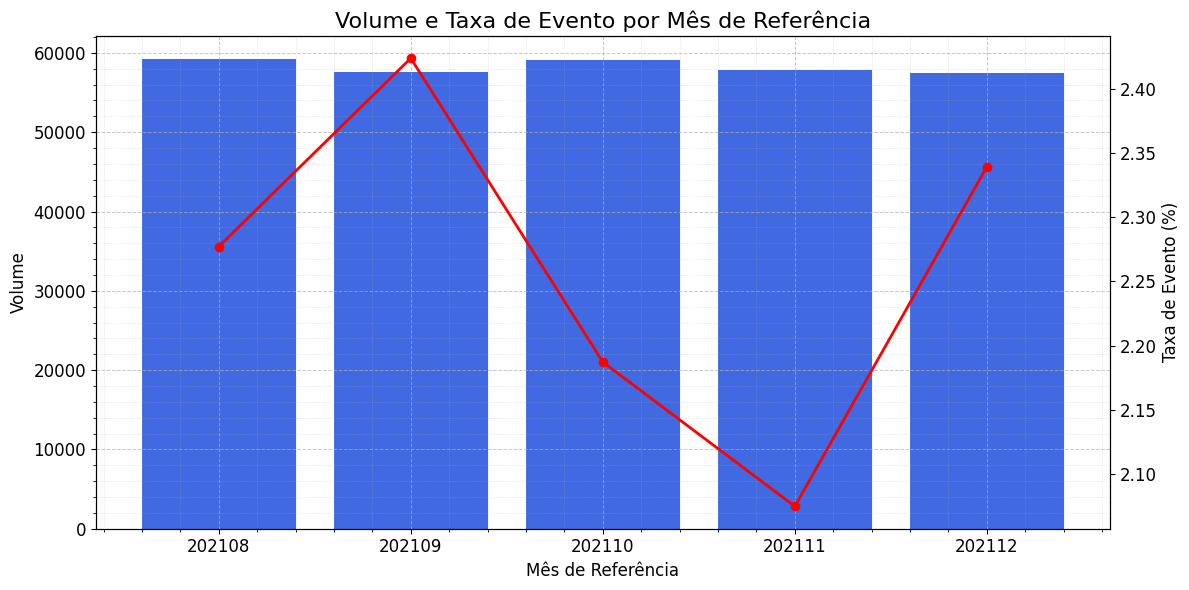

In [ ]:
# Preparando os DataFrames
df_ref_vol = df_train_merged.groupby('month_reference')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'Volume'})
df_ref_fraud = df_train_merged.groupby('month_reference')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='month_reference')

# Gráfico com barras para o volume e linha para a taxa de evento por month_reference
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando o gráfico de barras para o volume
color_bar = 'royalblue'
ax1.bar(df_plot['month_reference'], df_plot['Volume'], color=color_bar, label='Volume')
ax1.set_xlabel('Mês de Referência', fontsize=12, color='black')
ax1.set_ylabel('Volume', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Configurando eixos menores para melhorar a visualização do grid
ax1.minorticks_on()

# Plotando o gráfico de linha para a taxa de fraude
color_line = 'red'
ax2 = ax1.twinx()  # Cria um segundo eixo y
ax2.plot(df_plot['month_reference'], df_plot['TX_FRAUD'] * 100, marker='o', linestyle='-', color=color_line, linewidth=2, markersize=6, label='Taxa de Evento (%)')
ax2.set_ylabel('Taxa de Evento (%)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Ajustando a fonte e cor dos labels dos eixos
for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_color('black')

plt.title('Volume e Taxa de Evento por Mês de Referência', fontsize=16, color='black')
fig.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()

In [ ]:
df_train_merged.groupby('month_reference')['TX_FRAUD'].mean()

,TX_FRAUD
month_reference,
202108,0.022773
202109,0.024244
202110,0.021871
202111,0.020744
202112,0.023395


- O mês que teve a taxa de fraude mais alta foi Setembro de 2021, com 2,42%

- O mês com a taxa de fraude mais baixa foi Novembro de 2021 com 2,07%

### Volume de transações e taxa de fraude por terminal (ordenado por taxa de fraude)

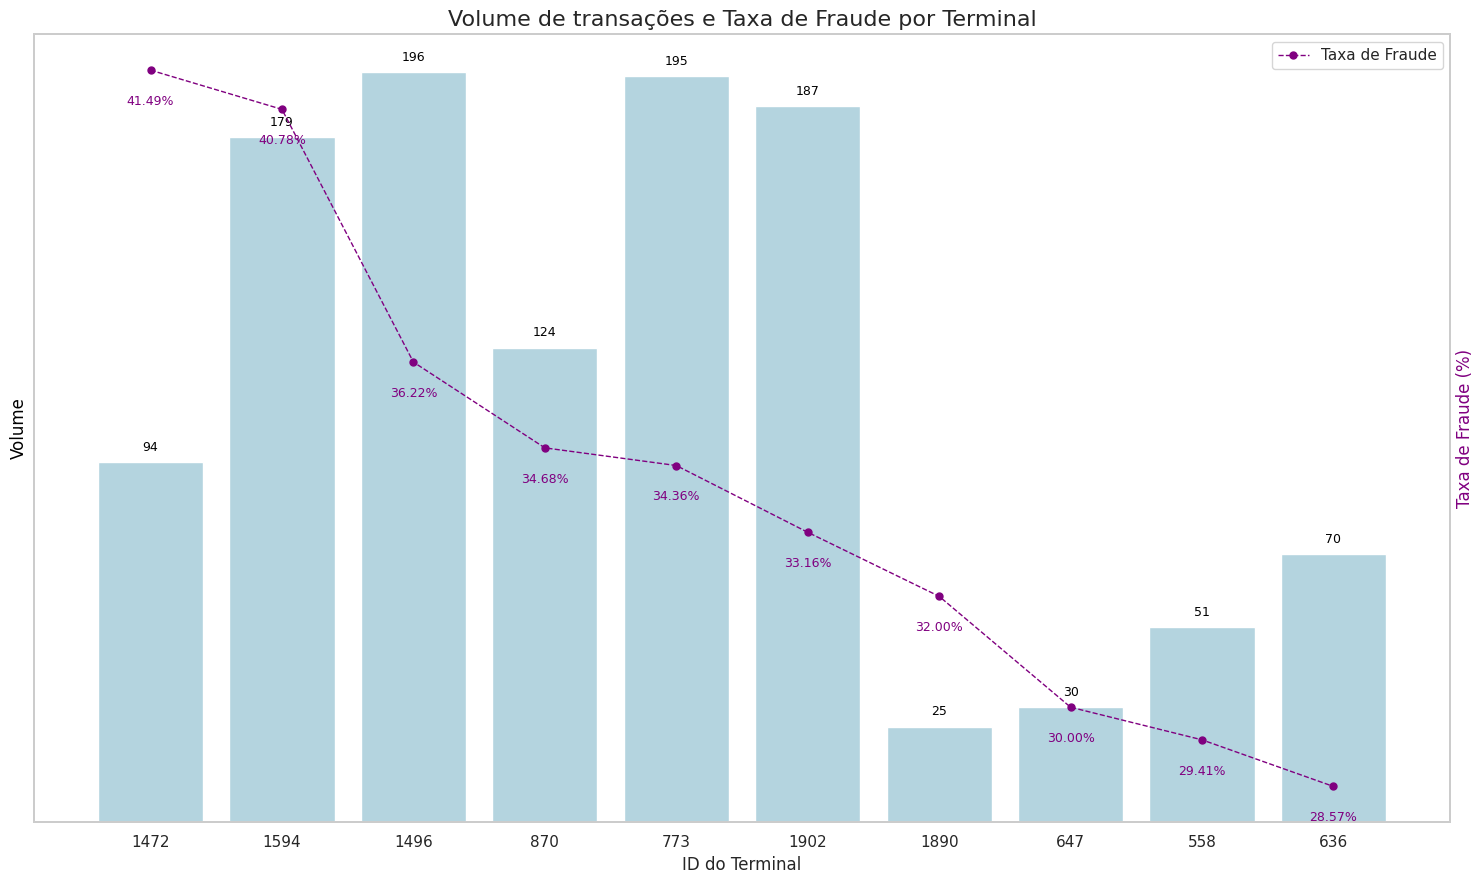

In [ ]:
df_ref_vol = df_train_merged.groupby('TERMINAL_ID')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'VOLUME'})
df_ref_fraud = df_train_merged.groupby('TERMINAL_ID')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='TERMINAL_ID')
df_plot = df_plot.sort_values(by=['TX_FRAUD','VOLUME'],ascending=False)[:10].copy()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plotando o gráfico de barras
barplot = sns.barplot(x=df_plot['TERMINAL_ID'].astype(str),
                      y=df_plot['VOLUME'],
                      color='lightblue',
                      ax=ax1)

# Criando o segundo eixo y para a linha de TX_FRAUD
ax2 = ax1.twinx()
lineplot = ax2.plot(df_plot['TERMINAL_ID'].astype(str),
                     df_plot['TX_FRAUD'],
                     color='purple',
                     marker='o',
                     linestyle='--',
                     linewidth=1,
                     markersize=5,
                     label='Taxa de Fraude')

# Ajustando os rótulos e título
ax1.set_xlabel('ID do Terminal', fontsize=12)
ax1.set_ylabel('Volume', fontsize=12, color='black')
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12, color='purple')
plt.title('Volume de transações e Taxa de Fraude por Terminal', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Removendo todas as linhas de grade
ax1.grid(False)
ax2.grid(False)

# Removendo números dos eixos verticais
ax1.set_yticks([])
ax2.set_yticks([])

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['VOLUME'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['VOLUME'].iloc[i]),
                 textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color='black')

# Adicionando rótulos na curva
for i in range(len(df_plot)):
    fraud_rate = df_plot['TX_FRAUD'].iloc[i]
    ax2.annotate(f'{100*fraud_rate:.2f}%',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['TX_FRAUD'].iloc[i]),
                 textcoords="offset points", xytext=(0,-25), ha='center', fontsize=9, color='purple')

# Adicionando a legenda para a linha de TX_FRAUD
ax2.legend(['Taxa de Fraude'], loc='upper right')

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibindo o gráfico
plt.show()

- O terminal 1472 teve 94 transações e 41,49% delas foram transações fraudulentas

- O terminal 1594 teve 179 transações e 40,78% delas foram transações fraudulentas

### Volume de transações e taxa de fraude por terminal (ordenado por quantidade de transações)

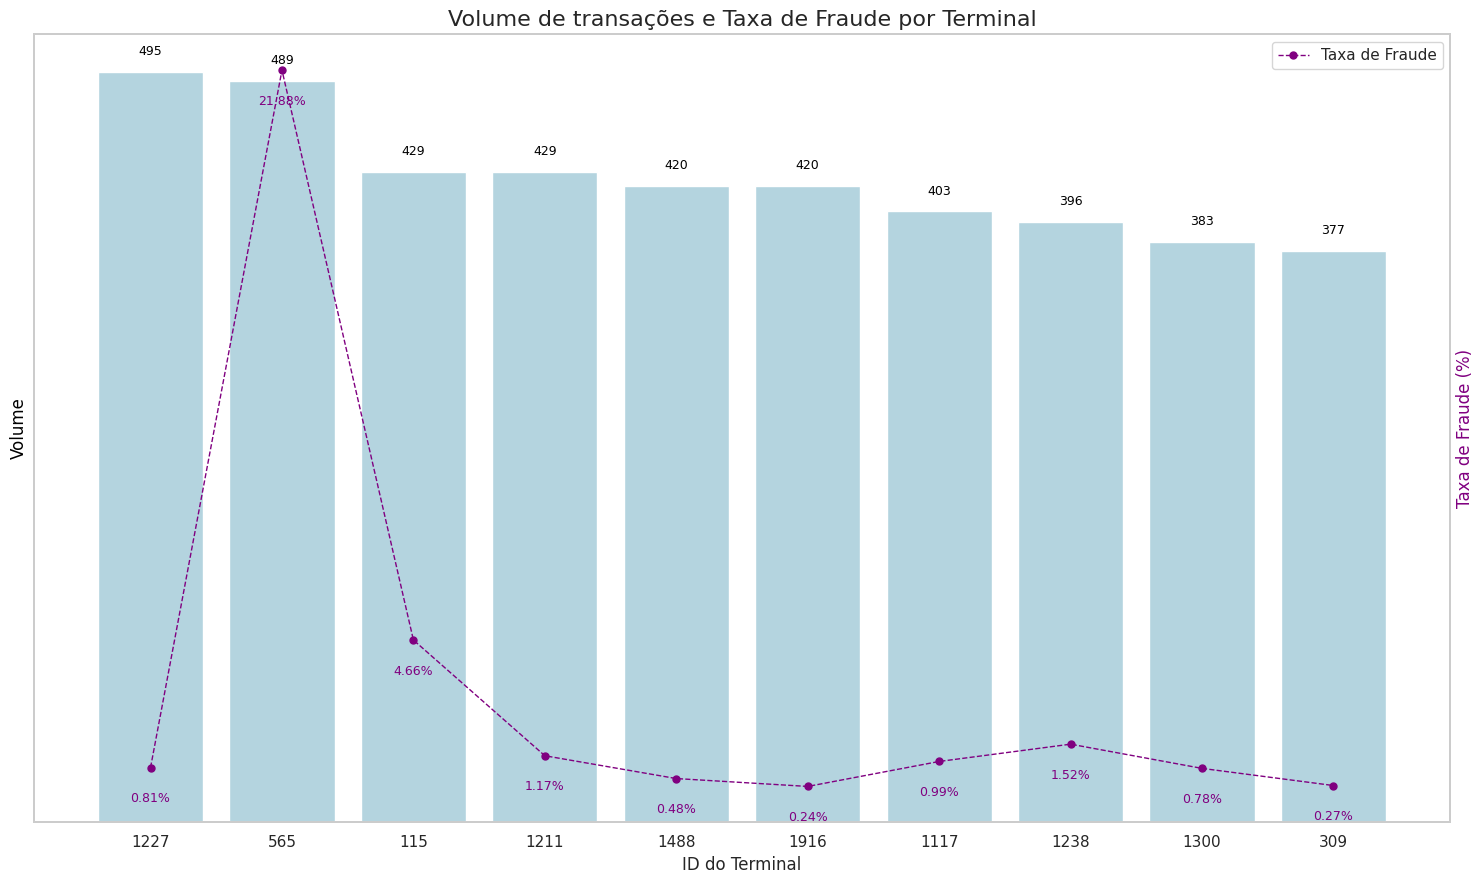

In [ ]:
df_ref_vol = df_train_merged.groupby('TERMINAL_ID')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'VOLUME'})
df_ref_fraud = df_train_merged.groupby('TERMINAL_ID')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='TERMINAL_ID')
df_plot = df_plot.sort_values(by=['VOLUME','TX_FRAUD'],ascending=False)[:10].copy()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plotando o gráfico de barras
barplot = sns.barplot(x=df_plot['TERMINAL_ID'].astype(str),
                      y=df_plot['VOLUME'],
                      color='lightblue',
                      ax=ax1)

# Criando o segundo eixo y para a linha de TX_FRAUD
ax2 = ax1.twinx()
lineplot = ax2.plot(df_plot['TERMINAL_ID'].astype(str),
                     df_plot['TX_FRAUD'],
                     color='purple',
                     marker='o',
                     linestyle='--',
                     linewidth=1,
                     markersize=5,
                     label='Taxa de Fraude')

# Ajustando os rótulos e título
ax1.set_xlabel('ID do Terminal', fontsize=12)
ax1.set_ylabel('Volume', fontsize=12, color='black')
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12, color='purple')
plt.title('Volume de transações e Taxa de Fraude por Terminal', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Removendo todas as linhas de grade
ax1.grid(False)
ax2.grid(False)

# Removendo números dos eixos verticais
ax1.set_yticks([])
ax2.set_yticks([])

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['VOLUME'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['VOLUME'].iloc[i]),
                 textcoords="offset points", xytext=(0,12), ha='center', fontsize=9, color='black')

# Adicionando rótulos na curva
for i in range(len(df_plot)):
    fraud_rate = df_plot['TX_FRAUD'].iloc[i]
    ax2.annotate(f'{100*fraud_rate:.2f}%',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['TX_FRAUD'].iloc[i]),
                 textcoords="offset points", xytext=(0,-25), ha='center', fontsize=9, color='purple')

# Adicionando a legenda para a linha de TX_FRAUD
ax2.legend(['Taxa de Fraude'], loc='upper right')

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [ ]:
taxa_fraude_terminal_565 = (df_train_merged[df_train_merged['TERMINAL_ID'] == 565]['TX_FRAUD'].mean()) * 100
taxa_fraude_media = df_train_merged['TX_FRAUD'].mean() * 100

taxa_fraude_terminal_565/taxa_fraude_media

np.float64(9.681767340935401)

- O terminal 565 teve 489 transações

- Sua média de fraude é de 21,88%

- É uma média de fraude 9,68 vezes maior que a média da base

### Volume de transações fraudulentas por terminal

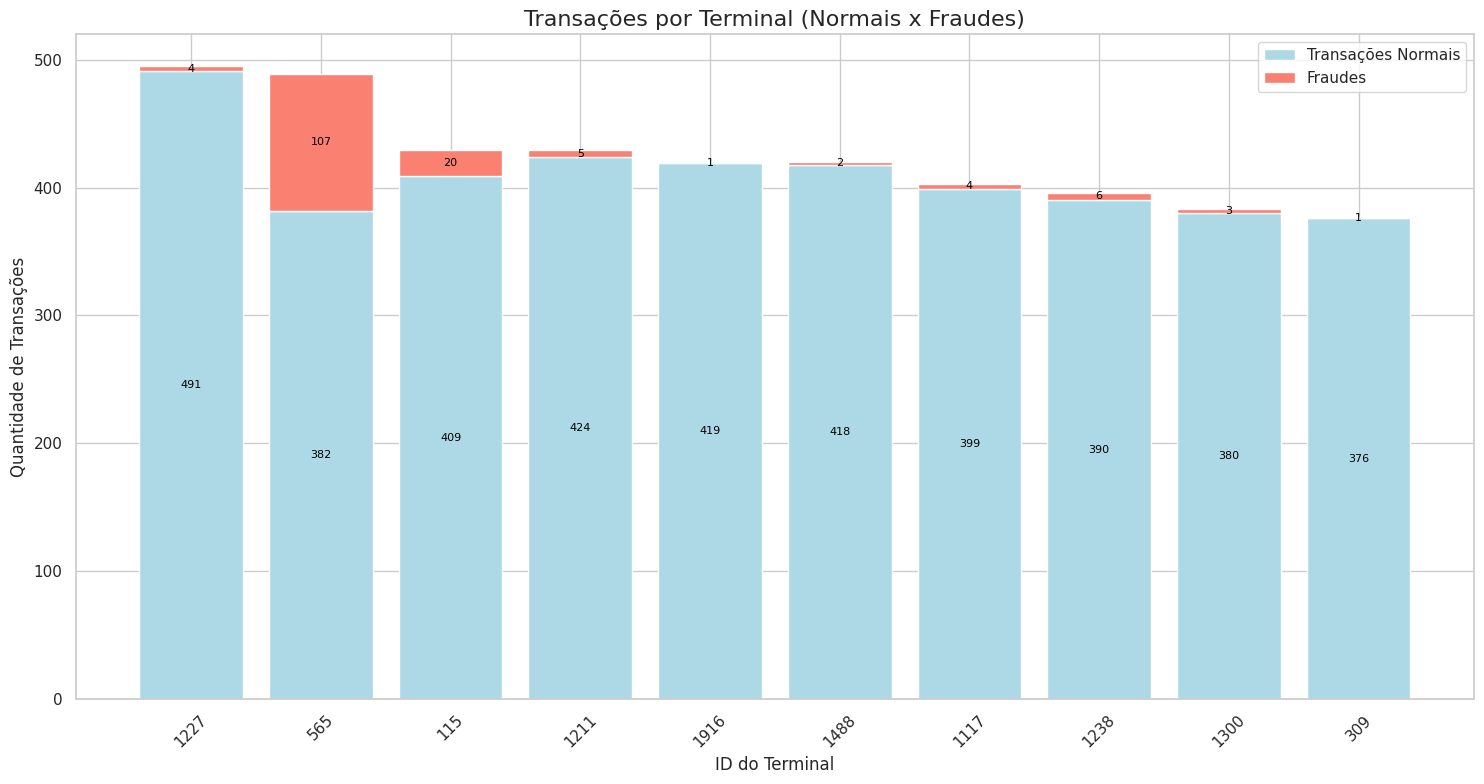

In [ ]:
# Agregando por terminal
df_terminal = df_train_merged.groupby('TERMINAL_ID').agg(
    TOTAL_TRANSACOES=('TRANSACTION_ID', 'count'),
    FRAUDES=('TX_FRAUD', 'sum')
).reset_index()

# Criando coluna de transações normais
df_terminal['NAO_FRAUDES'] = df_terminal['TOTAL_TRANSACOES'] - df_terminal['FRAUDES']

# Ordenando pelo volume (top 10)
df_terminal = df_terminal.sort_values(by='TOTAL_TRANSACOES', ascending=False).head(10)

# Estilo
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))

# Barras empilhadas
bars_normal = ax.bar(df_terminal['TERMINAL_ID'].astype(str), df_terminal['NAO_FRAUDES'],
                     label='Transações Normais', color='lightblue')
bars_fraud = ax.bar(df_terminal['TERMINAL_ID'].astype(str), df_terminal['FRAUDES'],
                    bottom=df_terminal['NAO_FRAUDES'], label='Fraudes', color='salmon')

# Títulos
ax.set_xlabel("ID do Terminal", fontsize=12)
ax.set_ylabel("Quantidade de Transações", fontsize=12)
ax.set_title("Transações por Terminal (Normais x Fraudes)", fontsize=16)
ax.legend()

# ---- Rótulos ----
for bar, row in zip(bars_normal, df_terminal.itertuples()):
    # Posição x e y da barra azul
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    ax.text(x, y, f"{int(row.NAO_FRAUDES)}", ha='center', va='center', fontsize=8, color='black')

for bar, row in zip(bars_fraud, df_terminal.itertuples()):
    # Posição x e y da barra vermelha (se houver fraudes)
    if row.FRAUDES > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + bar.get_height() / 2
        ax.text(x, y, f"{int(row.FRAUDES)}", ha='center', va='center', fontsize=8, color='black')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Volume de clientes que já esteve envolvido em uma transação fraudulenta

In [ ]:
# Calculando a quantidade de clientes envolvidos em transações fraudulentas
qtd_clientes_fraud = df_train_merged[df_train_merged.TX_FRAUD == 1].CUSTOMER_ID.nunique()

# Total de clientes
total_clientes = df_train_merged.CUSTOMER_ID.nunique()

# Calculando a representação percentual
percentual_fraud = 100 * qtd_clientes_fraud / total_clientes

print(f'Quantidade de clientes envolvidos em alguma transação fraudulenta no período: {qtd_clientes_fraud}\nTotal de clientes: {total_clientes}\nRepresentação percentual {percentual_fraud:.2f}%')

Quantidade de clientes envolvidos em alguma transação fraudulenta no período: 750
Total de clientes: 998
Representação percentual 75.15%


### Volume de clientes envolvidos em uma transação fraudulenta por mês de referência

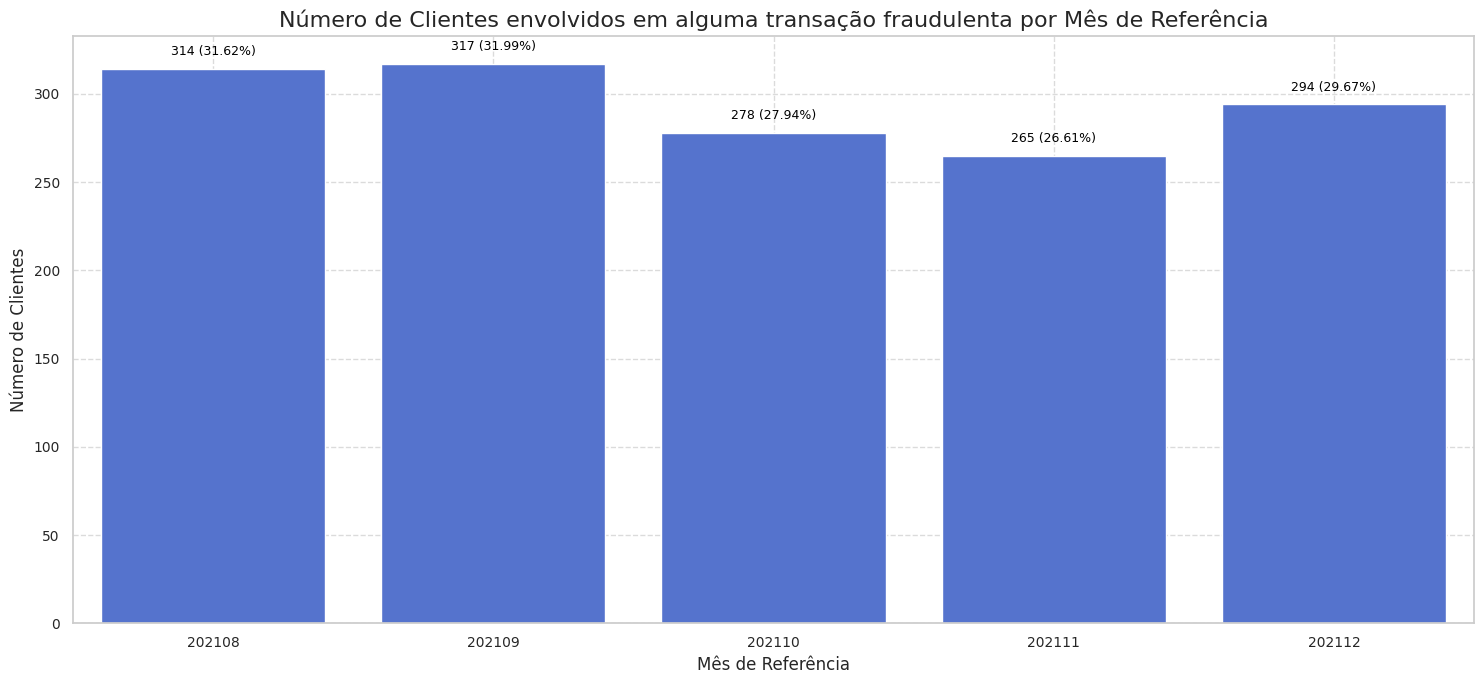

In [ ]:
df_total_customers = df_train_merged.groupby('month_reference')['CUSTOMER_ID'].nunique().reset_index()
df_total_customers = df_total_customers.rename(columns={'CUSTOMER_ID': 'Total_Customers'})

df_fraud_customers = df_train_merged[df_train_merged.TX_FRAUD == 1].groupby('month_reference')['CUSTOMER_ID'].nunique().reset_index()
df_fraud_customers = df_fraud_customers.rename(columns={'CUSTOMER_ID': 'Fraud_Customers'})

# Mesclando os DataFrames para ter total e fraudulento juntos
df_comparison = pd.merge(df_total_customers, df_fraud_customers, on='month_reference', how='inner')
df_comparison['Percent_Fraud'] = (df_comparison['Fraud_Customers'] / df_comparison['Total_Customers']) * 100

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de barras
plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=df_comparison['month_reference'].astype(str),
                      y=df_comparison['Fraud_Customers'],
                      color='royalblue')

# Ajustando os rótulos e título
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.title('Número de Clientes envolvidos em alguma transação fraudulenta por Mês de Referência', fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para número de clientes e percentual
for i in range(len(df_comparison)):
    num_clients = df_comparison['Fraud_Customers'].iloc[i]
    percent_fraud = df_comparison['Percent_Fraud'].iloc[i]
    plt.annotate(f'{num_clients} ({percent_fraud:.2f}%)',
                 (df_comparison['month_reference'].astype(str).iloc[i], df_comparison['Fraud_Customers'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

plt.show()

- Setembro de 2021 foi o mês onde mais clientes se envolveram em transações fraudulentas (cerca de 32% da base)

- Em novembro de 2021 cerca de 26,61% dos clientes se envolveram em transações fraudulentas

### Volume total de dinheiro movimentado em transações fraudulentas em todo o período

In [ ]:
total_dinheiro = df_train_merged[df_train_merged.TX_FRAUD == 1]['TX_AMOUNT'].sum()

print(f'O total de dinheiro movimentado em transações fraudulentas foi de ${total_dinheiro:.2f}')

O total de dinheiro movimentado em transações fraudulentas foi de $376210.13


### Volume de dinheiro movimentado em transações fraudulentas por mês

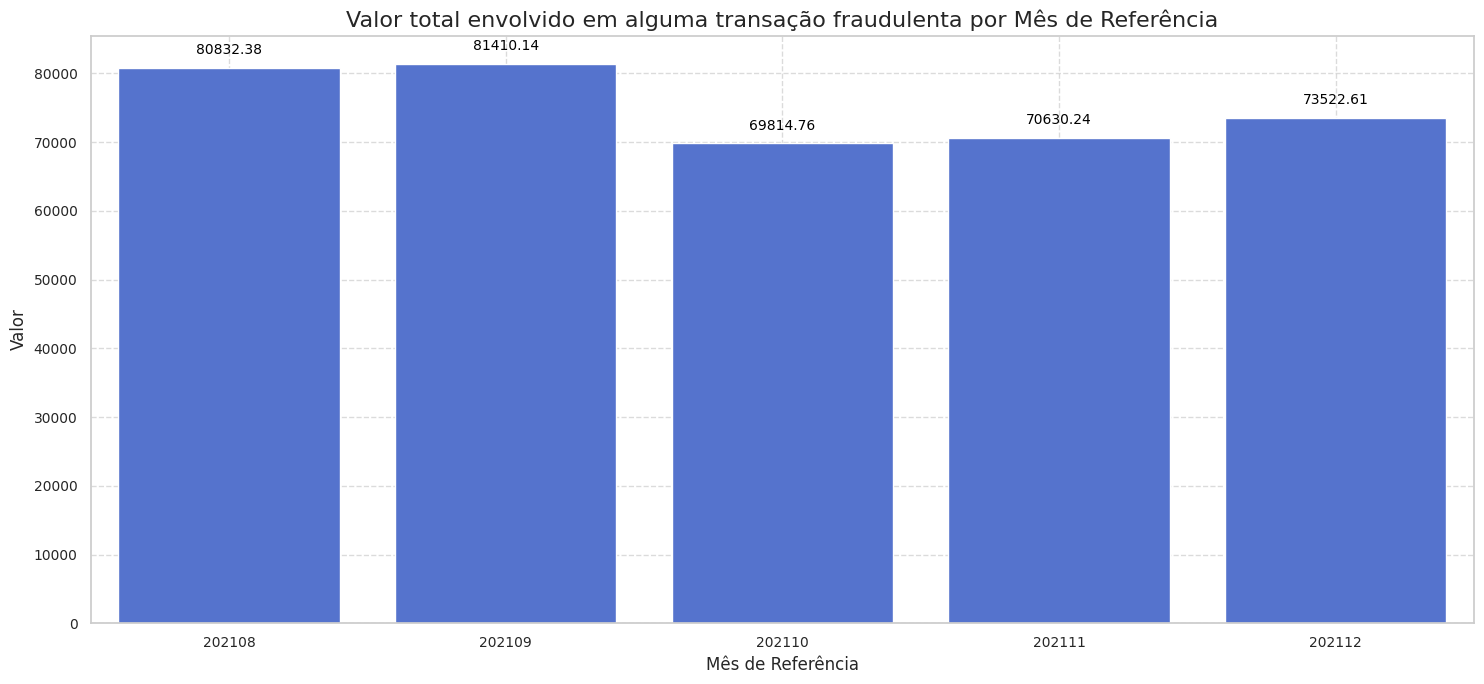

In [ ]:
df_amount = df_train_merged[df_train_merged.TX_FRAUD == 1].groupby('month_reference')['TX_AMOUNT'].sum().reset_index()

valor_total = df_amount.TX_AMOUNT.sum()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de barras
plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=df_amount['month_reference'].astype(str),
                      y=df_amount['TX_AMOUNT'],
                      color='royalblue')

# Ajustando os rótulos e título
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.title('Valor total envolvido em alguma transação fraudulenta por Mês de Referência', fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para número de clientes e percentual
for i in range(len(df_amount)):
    total_value_month_ref = df_amount['TX_AMOUNT'].iloc[i]
    plt.annotate(f'{total_value_month_ref}',
                 (df_amount['month_reference'].astype(str).iloc[i], df_amount['TX_AMOUNT'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='black')

plt.show()

- O total de dinheiro movimentado em transações fraudulentas foi de $ 376210,13

- O mês onde mais dinheiro foi movimentado foi setembro de 2021, onde foram movimentados $ 81410,14

- O mês de menor movimentação foi outubro de 2021, onde foram movimentados $ 69814,76

### Distribuição de valor de transação por grupo (fraude/não fraude)

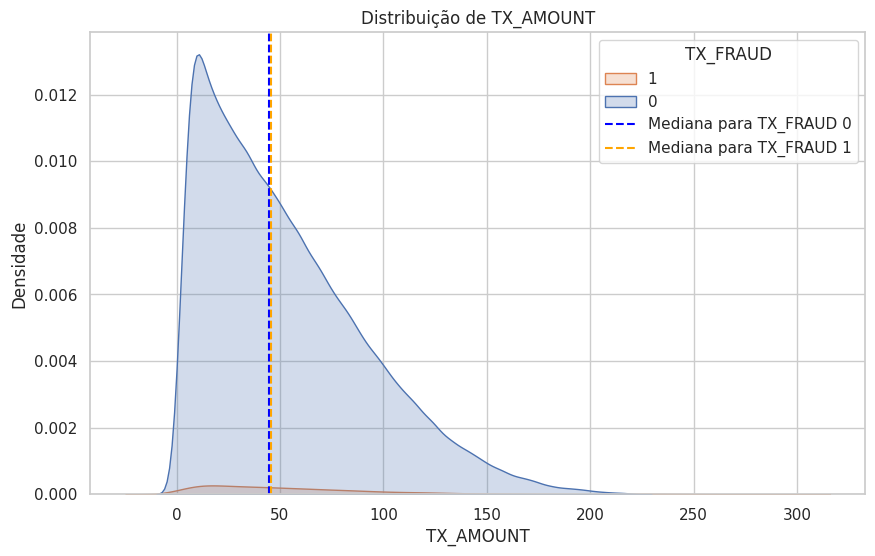

In [ ]:
var = 'TX_AMOUNT'

# Calcular as medianas para cada grupo
medianas = df_train_merged.groupby('TX_FRAUD')[var].median()

colors = ['blue','orange']
i = 0

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_train_merged, x=var, hue='TX_FRAUD', fill=True, warn_singular=False)

# Adicionar linhas verticais representando as medianas
for target, mediana in medianas.items():
    plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TX_FRAUD {target}')
    i += 1

plt.title(f'Distribuição de {var}')
plt.ylabel('Densidade')
plt.xlabel(f'{var}')
plt.legend(title='TX_FRAUD', loc='upper right', labels=['1', '0', 'Mediana para TX_FRAUD 0', 'Mediana para TX_FRAUD 1'])
plt.show()

### Teste de Mann-Whitney U (Não paramétrico)

In [ ]:
# Definindo os dois grupos
amostra1 = df_train_merged[train.TX_FRAUD == 0]['TX_AMOUNT']
amostra2 = df_train_merged[train.TX_FRAUD == 1]['TX_AMOUNT']

In [ ]:
# Realizando o teste de Mann-Whitney U
stat, p_value = mannwhitneyu(amostra1, amostra2, alternative='less')

print(f'Estatística U: {stat}')
print(f'Valor p: {p_value}')

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os grupos.")
else:
    print("Não rejeitamos a hipótese nula. Não podemos afirmar que há diferença estatisticamente significativa entre os grupos.")

Estatística U: 918469532.5
Valor p: 0.0033098149945866543
Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os grupos.


### Volume de transações por período do dia

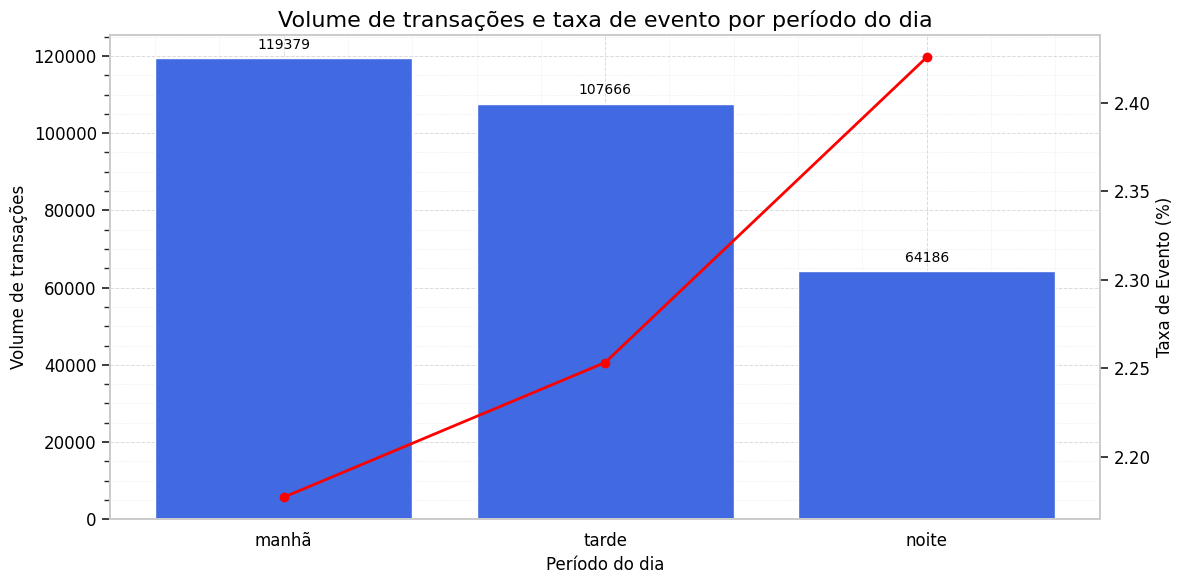

In [ ]:
# Preparando os DataFrames
df_ref_vol = df_train_merged.groupby('PERIODO_DIA')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'Volume'})
df_ref_fraud = df_train_merged.groupby('PERIODO_DIA')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='PERIODO_DIA')

# Definir uma ordem personalizada para a coluna 'PERIODO_DIA'
ordem_periodos = ['manhã', 'tarde', 'noite']
df_plot['PERIODO_DIA'] = pd.Categorical(df_plot['PERIODO_DIA'], categories=ordem_periodos, ordered=True)

# Ordenar o DataFrame pela coluna 'PERIODO_DIA'
df_plot = df_plot.sort_values(by='PERIODO_DIA')

# Gráfico com barras para o volume e linha para a taxa de evento por PERIODO_DIA
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando o gráfico de barras para o volume
color_bar = 'royalblue'
ax1.bar(df_plot['PERIODO_DIA'], df_plot['Volume'], color=color_bar, label='Volume')
ax1.set_xlabel('Período do dia', fontsize=12, color='black')
ax1.set_ylabel('Volume de transações', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Configurando eixos menores para melhorar a visualização do grid
ax1.minorticks_on()

# Plotando o gráfico de linha para a taxa de fraude
color_line = 'red'
ax2 = ax1.twinx()  # Cria um segundo eixo y
ax2.plot(df_plot['PERIODO_DIA'], df_plot['TX_FRAUD'] * 100, marker='o', linestyle='-', color=color_line, linewidth=2, markersize=6, label='Taxa de Evento (%)')
ax2.set_ylabel('Taxa de Evento (%)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Ajustando a fonte e cor dos labels dos eixos
for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_color('black')

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['Volume'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['PERIODO_DIA'].astype(str).iloc[i], df_plot['Volume'].iloc[i]),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=10, color='black')

plt.title('Volume de transações e taxa de evento por período do dia', fontsize=16, color='black')
fig.tight_layout()
plt.xticks(rotation=0, ha='right')
plt.grid(False)
plt.show()

- A maior parte das transações ocorre no período da manhã, seguido pelo período da tarde

- A taxa de fraude aumenta no período da noite

### Volume de dinheiro movimentado por período do dia

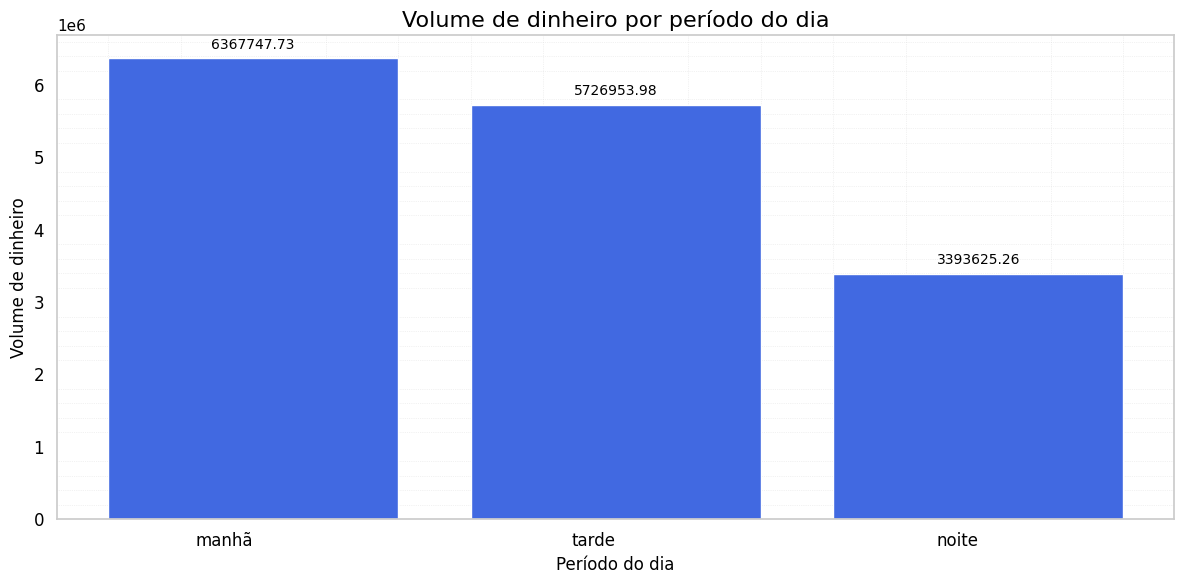

In [ ]:
# Preparando os DataFrames
df_ref_vol = df_train_merged.groupby('PERIODO_DIA')['TX_AMOUNT'].sum().reset_index().rename(columns={'TX_AMOUNT': 'Volume'})
df_ref_fraud = df_train_merged.groupby('PERIODO_DIA')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='PERIODO_DIA')

# Definir uma ordem personalizada para a coluna 'PERIODO_DIA'
ordem_periodos = ['manhã', 'tarde', 'noite']
df_plot['PERIODO_DIA'] = pd.Categorical(df_plot['PERIODO_DIA'], categories=ordem_periodos, ordered=True)

# Ordenar o DataFrame pela coluna 'PERIODO_DIA'
df_plot = df_plot.sort_values(by='PERIODO_DIA')

# Gráfico com barras para o volume e linha para a taxa de evento por PERIODO_DIA
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando o gráfico de barras para o volume
color_bar = 'royalblue'
ax1.bar(df_plot['PERIODO_DIA'], df_plot['Volume'], color=color_bar, label='Volume')
ax1.set_xlabel('Período do dia', fontsize=12, color='black')
ax1.set_ylabel('Volume de dinheiro', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Configurando eixos menores para melhorar a visualização do grid
ax1.minorticks_on()


# Ajustando a fonte e cor dos labels dos eixos
for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_color('black')

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['Volume'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['PERIODO_DIA'].astype(str).iloc[i], df_plot['Volume'].iloc[i]),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=10, color='black')

plt.title('Volume de dinheiro por período do dia', fontsize=16, color='black')
fig.tight_layout()
plt.xticks(rotation=0, ha='right')
plt.grid(False)
plt.show()

- A maior parte do dinheiro é movimentada no período da manhã

- No período da noite é movimentado um pouco mais da metade do dinheiro movimentado no período da manhã

### Distribuição de valor de transação para os grupos (Fraude/Não fraude) por período do dia

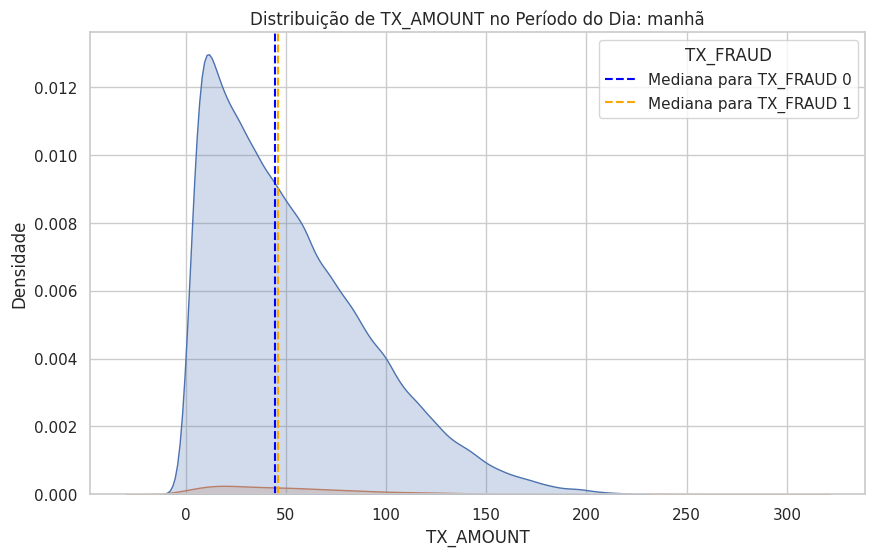

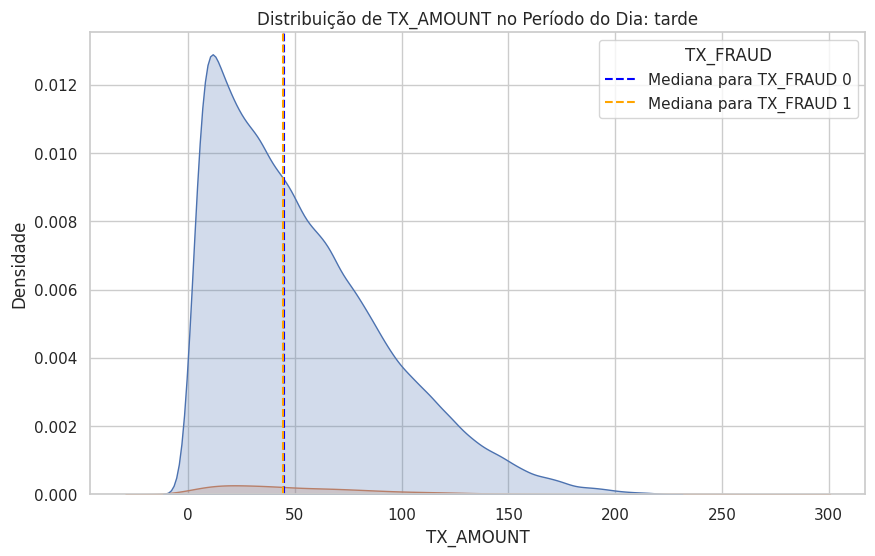

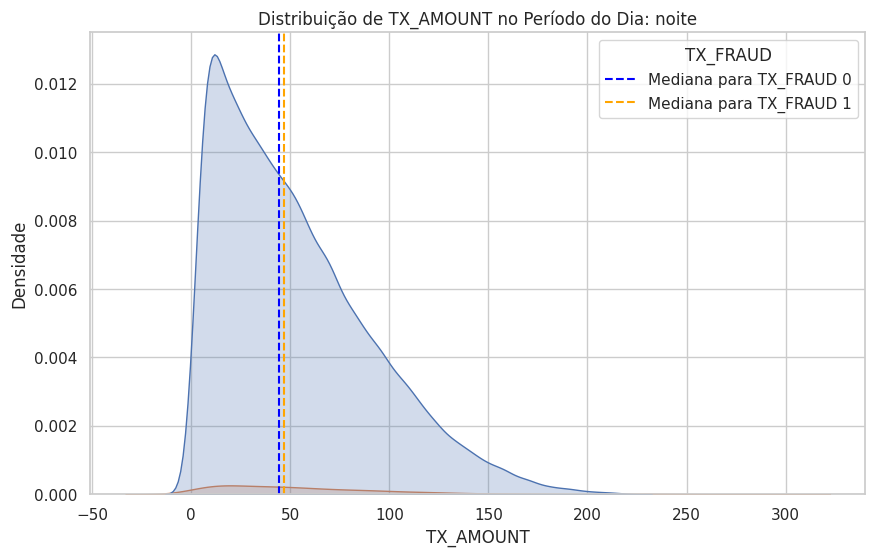

In [ ]:
# Definir cores
colors = ['blue', 'orange']

# Iterar sobre cada período do dia e plotar o gráfico correspondente
for periodo in ordem_periodos:
    plt.figure(figsize=(10, 6))

    # Filtrar os dados para o período atual
    subset = df_train_merged[df_train_merged['PERIODO_DIA'] == periodo]

    # Calcular as medianas para cada grupo
    medianas = subset.groupby('TX_FRAUD')['TX_AMOUNT'].median()

    # Plotar a densidade
    sns.kdeplot(data=subset, x='TX_AMOUNT', hue='TX_FRAUD', fill=True, warn_singular=False)

    # Adicionar linhas verticais representando as medianas
    for i, (target, mediana) in enumerate(medianas.items()):
        plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TX_FRAUD {target}')

    plt.title(f'Distribuição de TX_AMOUNT no Período do Dia: {periodo}')
    plt.ylabel('Densidade')
    plt.xlabel('TX_AMOUNT')
    plt.legend(title='TX_FRAUD', loc='upper right')
    plt.show()

- Na parte da noite é onde podemos ver mais diferença entre os grupos

### Volume de transações por cliente (top 10 por total de transações)

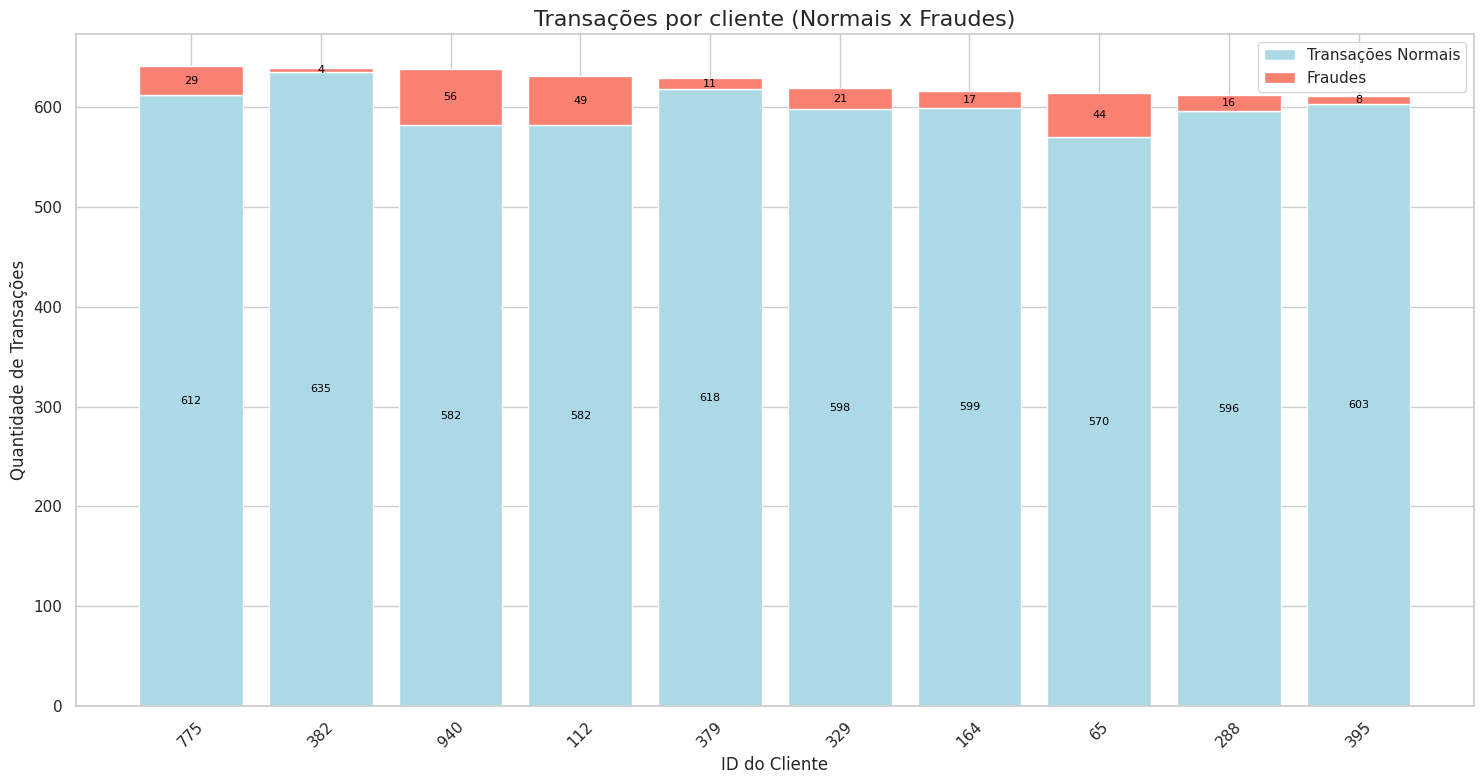

In [ ]:
# Agregando por cliente
df_terminal = df_train_merged.groupby('CUSTOMER_ID').agg(
    TOTAL_TRANSACOES=('TRANSACTION_ID', 'count'),
    FRAUDES=('TX_FRAUD', 'sum')
).reset_index()

# Criando coluna de transações normais
df_terminal['NAO_FRAUDES'] = df_terminal['TOTAL_TRANSACOES'] - df_terminal['FRAUDES']

# Ordenando pelo volume (top 10)
df_terminal = df_terminal.sort_values(by='TOTAL_TRANSACOES', ascending=False).head(10)

# Estilo
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))

# Barras empilhadas
bars_normal = ax.bar(df_terminal['CUSTOMER_ID'].astype(str), df_terminal['NAO_FRAUDES'],
                     label='Transações Normais', color='lightblue')
bars_fraud = ax.bar(df_terminal['CUSTOMER_ID'].astype(str), df_terminal['FRAUDES'],
                    bottom=df_terminal['NAO_FRAUDES'], label='Fraudes', color='salmon')

# Títulos
ax.set_xlabel("ID do Cliente", fontsize=12)
ax.set_ylabel("Quantidade de Transações", fontsize=12)
ax.set_title("Transações por cliente (Normais x Fraudes)", fontsize=16)
ax.legend()

# ---- Rótulos ----
for bar, row in zip(bars_normal, df_terminal.itertuples()):
    # Posição x e y da barra azul
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    ax.text(x, y, f"{int(row.NAO_FRAUDES)}", ha='center', va='center', fontsize=8, color='black')

for bar, row in zip(bars_fraud, df_terminal.itertuples()):
    # Posição x e y da barra vermelha (se houver fraudes)
    if row.FRAUDES > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + bar.get_height() / 2
        ax.text(x, y, f"{int(row.FRAUDES)}", ha='center', va='center', fontsize=8, color='black')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Volume de transações por cliente (top 10 por transações fraudulentas)

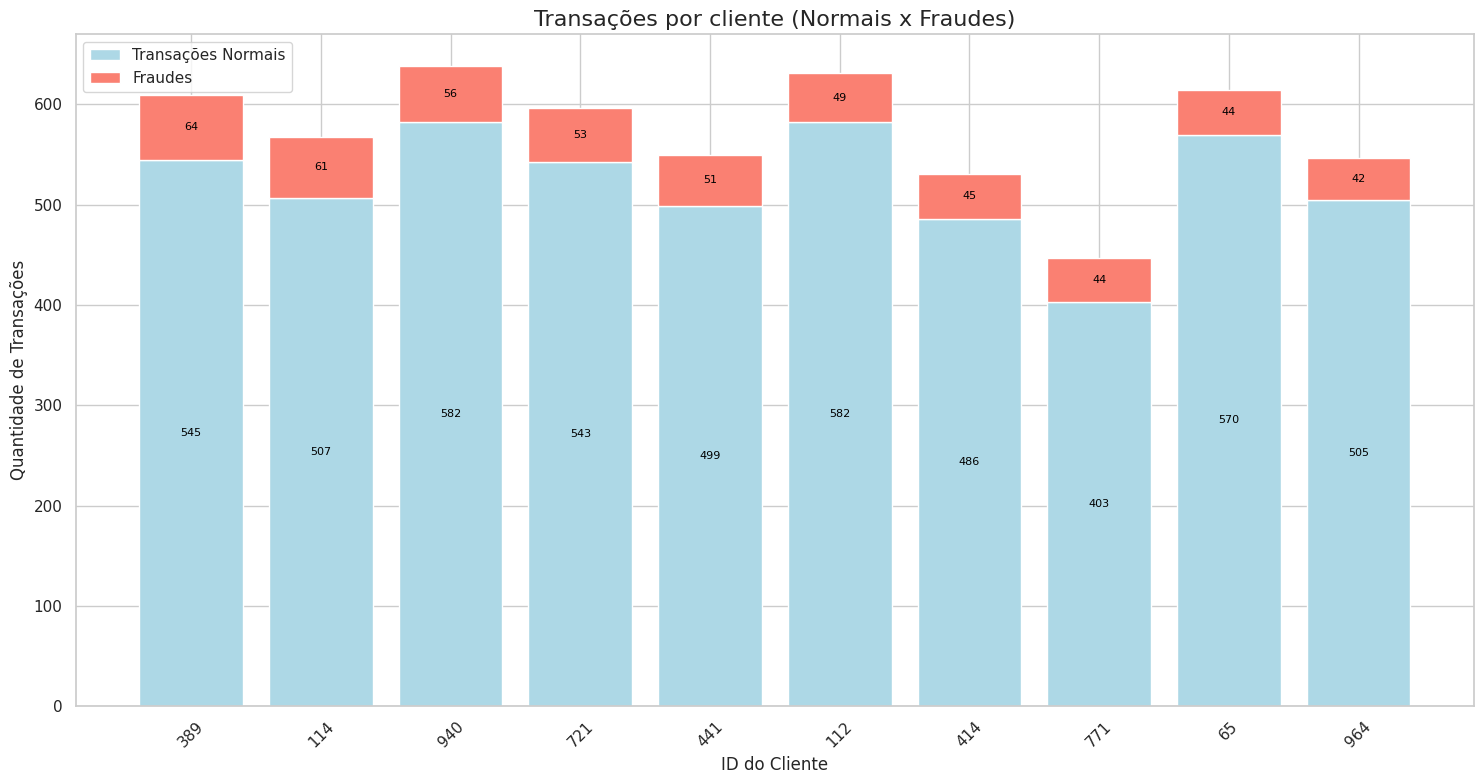

In [ ]:
# Agregando por terminal
df_terminal = df_train_merged.groupby('CUSTOMER_ID').agg(
    TOTAL_TRANSACOES=('TRANSACTION_ID', 'count'),
    FRAUDES=('TX_FRAUD', 'sum')
).reset_index()

# Criando coluna de transações normais
df_terminal['NAO_FRAUDES'] = df_terminal['TOTAL_TRANSACOES'] - df_terminal['FRAUDES']

# Ordenando pelo volume (top 10)
df_terminal = df_terminal.sort_values(by='FRAUDES', ascending=False).head(10)

# Estilo
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(15, 8))

# Barras empilhadas
bars_normal = ax.bar(df_terminal['CUSTOMER_ID'].astype(str), df_terminal['NAO_FRAUDES'],
                     label='Transações Normais', color='lightblue')
bars_fraud = ax.bar(df_terminal['CUSTOMER_ID'].astype(str), df_terminal['FRAUDES'],
                    bottom=df_terminal['NAO_FRAUDES'], label='Fraudes', color='salmon')

# Títulos
ax.set_xlabel("ID do Cliente", fontsize=12)
ax.set_ylabel("Quantidade de Transações", fontsize=12)
ax.set_title("Transações por cliente (Normais x Fraudes)", fontsize=16)
ax.legend()

# ---- Rótulos ----
for bar, row in zip(bars_normal, df_terminal.itertuples()):
    # Posição x e y da barra azul
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height() / 2
    ax.text(x, y, f"{int(row.NAO_FRAUDES)}", ha='center', va='center', fontsize=8, color='black')

for bar, row in zip(bars_fraud, df_terminal.itertuples()):
    # Posição x e y da barra vermelha (se houver fraudes)
    if row.FRAUDES > 0:
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_y() + bar.get_height() / 2
        ax.text(x, y, f"{int(row.FRAUDES)}", ha='center', va='center', fontsize=8, color='black')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Localização dos clientes

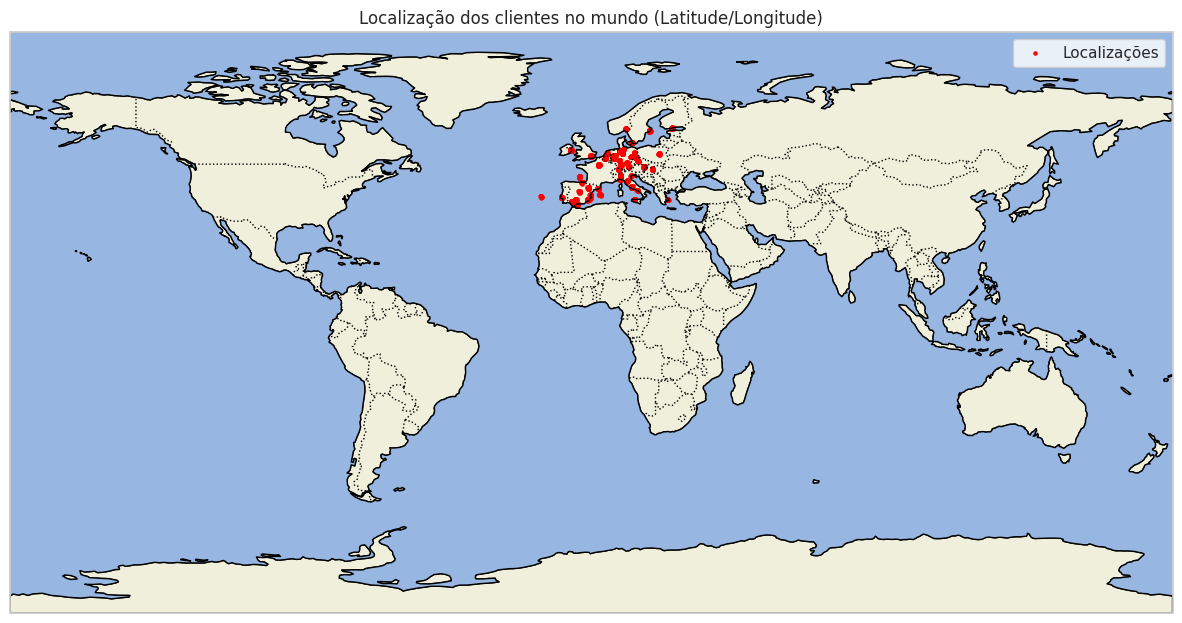

In [ ]:
# Criando o plot com Cartopy
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Define a projeção para o gráfico
ax.set_extent([-180, 180, -90, 90])  # Define os limites do gráfico (global)

# Adiciona características ao mapa como costas, estados e países
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando as coordenadas no mapa
plt.scatter(customer['x_customer_id'], customer['y_customer_id'],
            color='red', marker='o', s=5, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Localização dos clientes no mundo (Latitude/Longitude)')
plt.legend()
plt.show()

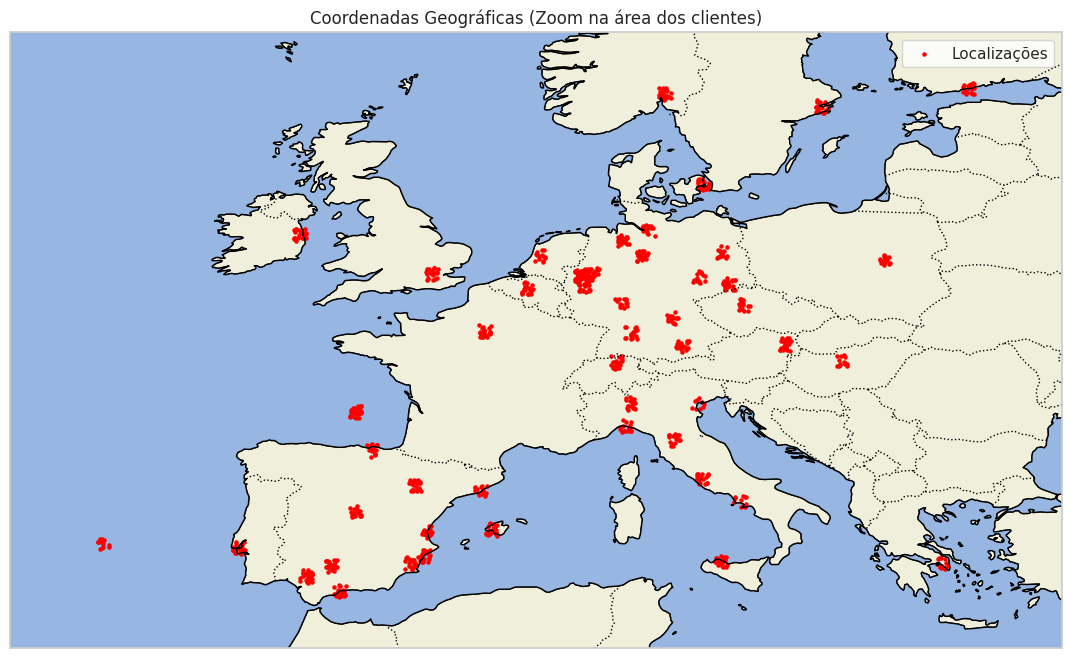

In [ ]:

# Coordenadas mínimas e máximas dos clientes
lon_min, lon_max = customer['x_customer_id'].min(), customer['x_customer_id'].max()
lat_min, lat_max = customer['y_customer_id'].min(), customer['y_customer_id'].max()

# Margem extra para não cortar os pontos (10% do range)
lon_margin = (lon_max - lon_min) * 0.1
lat_margin = (lat_max - lat_min) * 0.1

# Criando o plot com zoom na área dos clientes
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - lon_margin, lon_max + lon_margin,
               lat_min - lat_margin, lat_max + lat_margin],
              crs=ccrs.PlateCarree())

# Adiciona camadas
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando os pontos
plt.scatter(customer['x_customer_id'], customer['y_customer_id'],
            color='red', marker='o', s=5, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Coordenadas Geográficas (Zoom na área dos clientes)')
plt.legend()
plt.show()

### Localização dos terminais

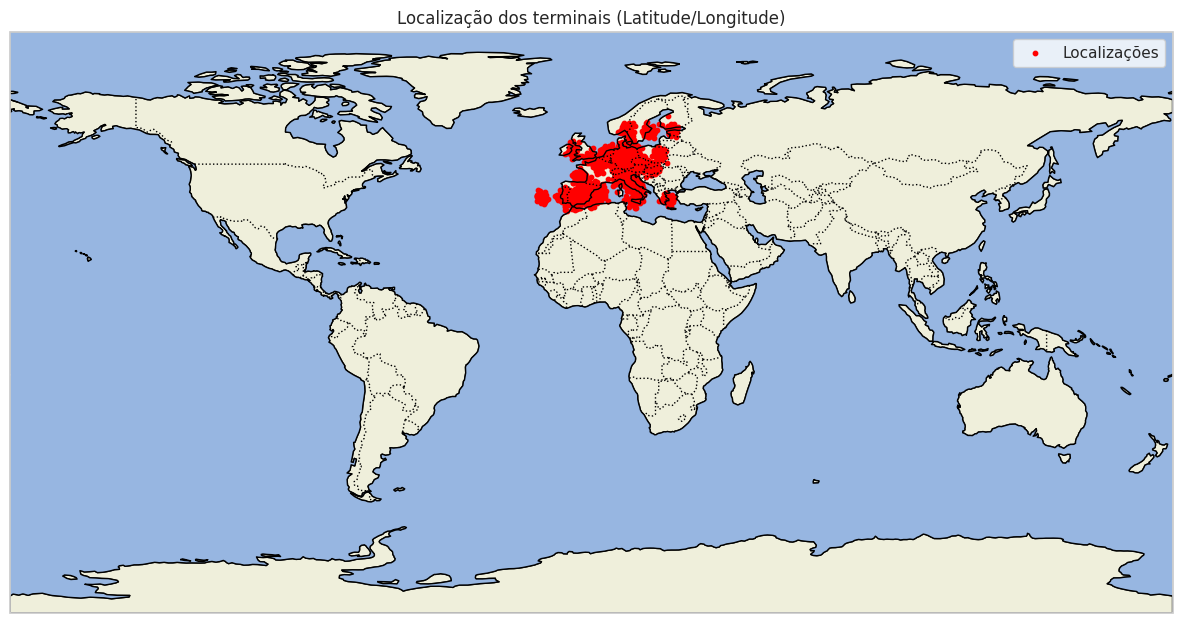

In [ ]:
# Criando o plot com Cartopy
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Define a projeção para o gráfico
ax.set_extent([-180, 180, -90, 90])  # Define os limites do gráfico (global)

# Adiciona características ao mapa como costas, estados e países
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando as coordenadas no mapa
plt.scatter(terminal['x_terminal_id'], terminal['y_terminal_id'],
            color='red', marker='o', s=10, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Localização dos terminais (Latitude/Longitude)')
plt.legend()
plt.show()

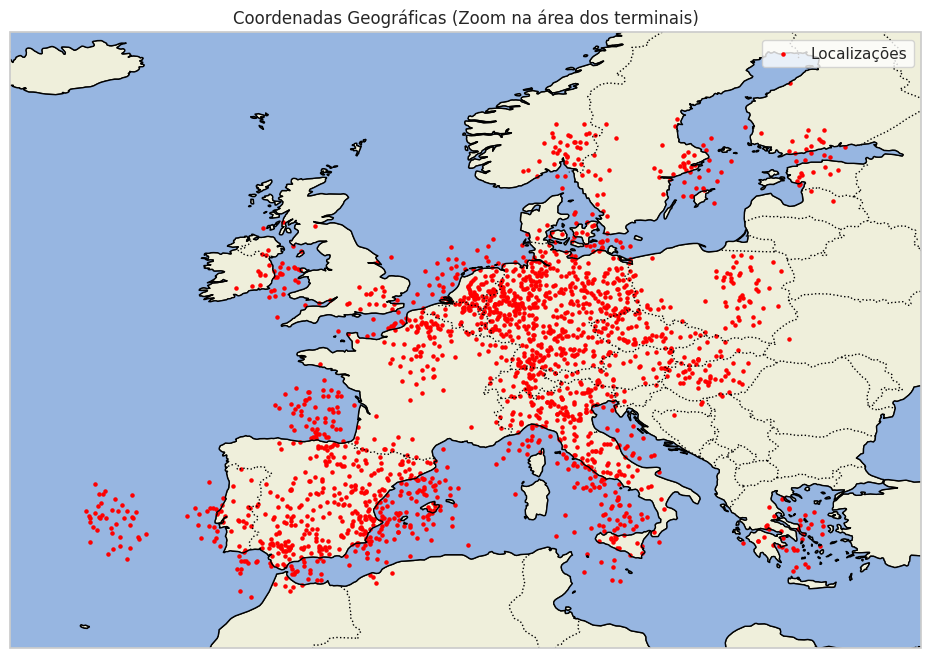

In [ ]:
# Coordenadas mínimas e máximas dos terminais
lon_min, lon_max = terminal['x_terminal_id'].min(), terminal['x_terminal_id'].max()
lat_min, lat_max = terminal['y_terminal_id'].min(), terminal['y_terminal_id'].max()

# Margem extra para não cortar os pontos (10% do range)
lon_margin = (lon_max - lon_min) * 0.1
lat_margin = (lat_max - lat_min) * 0.1

# Criando o plot com zoom na área dos clientes
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min - lon_margin, lon_max + lon_margin,
               lat_min - lat_margin, lat_max + lat_margin],
              crs=ccrs.PlateCarree())

# Adiciona camadas
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando os pontos
plt.scatter(terminal['x_terminal_id'], terminal['y_terminal_id'],
            color='red', marker='o', s=5, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Coordenadas Geográficas (Zoom na área dos terminais)')
plt.legend()
plt.show()